# 03 - Visualisations Avancees - Phase 5

**Projet :** Electio-Analytics - Prediction Presidentielles 2027  
**Objectif :** Cartes choropletres, courbes d'evolution, intervalles de confiance  
**Perimetre :** 534 communes de Gironde (departement 33)  

---

## Contenu

1. Chargement des predictions 2027 depuis PostgreSQL
2. Carte chorolethe : predictions par commune (Folium)
3. Evolution 2017 → 2022 → 2027 (courbes par candidat)
4. Intervalles de confiance (barres d'erreur)
5. Top/Bottom communes par candidat
6. Synthese visuelle pour la soutenance

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

import sys, os
sys.path.insert(0, '..')
os.makedirs('../docs/figures/visualisation', exist_ok=True)

from sqlalchemy import func
from src.database.config import get_engine, get_session
from src.database.models import (
    Commune, Election, Candidat,
    ResultatParticipation, ResultatCandidat,
    Prediction
)

engine = get_engine()
session = get_session()
print('Connexion DB OK')

Connexion DB OK


In [2]:
# Charger predictions 2027 depuis PostgreSQL
query_pred = session.query(
    Prediction.id_territoire,
    Prediction.candidat,
    Prediction.pourcentage_predit,
    Prediction.intervalle_confiance_inf,
    Prediction.intervalle_confiance_sup,
    Prediction.metriques_modele
).filter(
    Prediction.annee_prediction == 2027,
    Prediction.version_modele == 'v1.0.0',
    Prediction.type_territoire == 'COMMUNE'
)
df_pred = pd.read_sql(query_pred.statement, session.bind)
df_pred['pourcentage_predit'] = df_pred['pourcentage_predit'].astype(float)
df_pred['intervalle_confiance_inf'] = df_pred['intervalle_confiance_inf'].astype(float)
df_pred['intervalle_confiance_sup'] = df_pred['intervalle_confiance_sup'].astype(float)

# Charger communes
query_communes = session.query(
    Commune.id_commune, Commune.nom_commune, Commune.population
).filter(Commune.id_departement == '33')
df_communes = pd.read_sql(query_communes.statement, session.bind)

# Charger resultats historiques (T1 uniquement)
query_hist = session.query(
    ResultatCandidat.id_territoire,
    ResultatCandidat.tour,
    ResultatCandidat.pourcentage_voix_exprimes,
    Election.annee,
    Candidat.nom,
    Candidat.prenom
).join(
    Election, ResultatCandidat.id_election == Election.id_election
).join(
    Candidat, ResultatCandidat.id_candidat == Candidat.id_candidat
).filter(
    ResultatCandidat.type_territoire == 'COMMUNE',
    ResultatCandidat.tour == 1
)
df_hist = pd.read_sql(query_hist.statement, session.bind)
df_hist['commune_id'] = df_hist['id_territoire'].str[2:]
df_hist['candidat_nom'] = df_hist['prenom'] + ' ' + df_hist['nom']
df_hist['pct'] = df_hist['pourcentage_voix_exprimes'].fillna(0).astype(float)

# Joindre communes aux predictions
df_pred = df_pred.merge(df_communes, left_on='id_territoire', right_on='id_commune', how='left')

print(f'Predictions : {len(df_pred)} lignes')
print(f'Communes    : {len(df_communes)}')
print(f'Historique  : {len(df_hist)} lignes')
print(f'Candidats predits : {df_pred["candidat"].unique().tolist()}')

Predictions : 3745 lignes
Communes    : 534
Historique  : 12338 lignes
Candidats predits : ['Emmanuel MACRON', 'Jean LASSALLE', 'Jean-Luc MÉLENCHON', 'Marine LE PEN', 'Nathalie ARTHAUD', 'Nicolas DUPONT-AIGNAN', 'Philippe POUTOU']


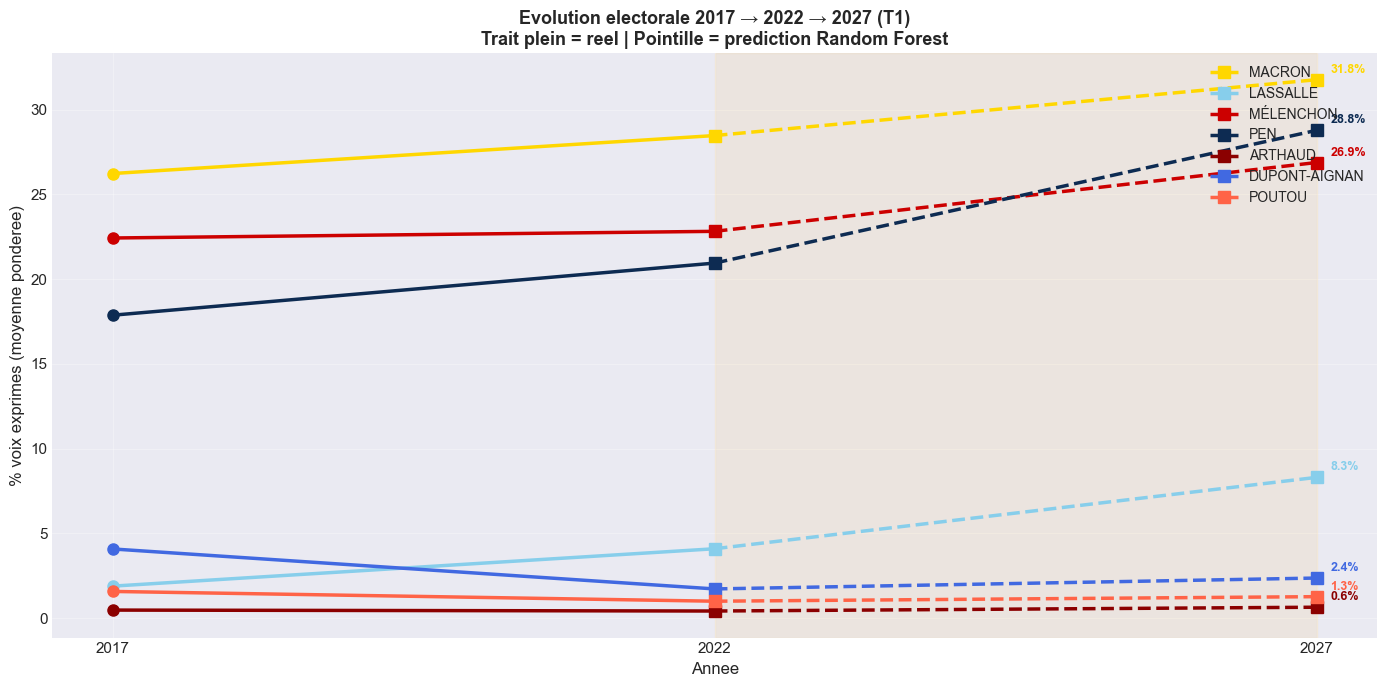

Figure sauvegardee : evolution_2017_2022_2027.png


In [3]:
# ============================================================
# FIGURE 1 : Evolution 2017 -> 2022 -> 2027 par candidat
# ============================================================

# 7 candidats communs
candidats_communs = sorted(df_pred['candidat'].unique())

# Moyennes historiques ponderees par population
evolution = []

for candidat in candidats_communs:
    nom_court = candidat.split()[-1]
    
    for annee in [2017, 2022]:
        sub = df_hist[(df_hist['candidat_nom'] == candidat) & (df_hist['annee'] == annee)]
        sub = sub.merge(df_communes[['id_commune', 'population']], left_on='commune_id', right_on='id_commune', how='left')
        pop = sub['population'].fillna(0)
        if pop.sum() > 0:
            moy = np.average(sub['pct'], weights=pop)
        else:
            moy = sub['pct'].mean()
        evolution.append({'candidat': candidat, 'annee': annee, 'pct': moy})
    
    # 2027 : moyenne ponderee des predictions
    sub_pred = df_pred[df_pred['candidat'] == candidat]
    pop_pred = sub_pred['population'].fillna(0)
    if pop_pred.sum() > 0:
        moy_2027 = np.average(sub_pred['pourcentage_predit'], weights=pop_pred)
    else:
        moy_2027 = sub_pred['pourcentage_predit'].mean()
    evolution.append({'candidat': candidat, 'annee': 2027, 'pct': moy_2027})

df_evo = pd.DataFrame(evolution)

# Couleurs par candidat
couleurs = {
    'Emmanuel MACRON': '#FFD700',
    'Marine LE PEN': '#0D2B52',
    'Jean-Luc MELENCHON': '#CC0000',
    'Jean-Luc MÉLENCHON': '#CC0000',
    'Jean LASSALLE': '#87CEEB',
    'Nathalie ARTHAUD': '#8B0000',
    'Nicolas DUPONT-AIGNAN': '#4169E1',
    'Philippe POUTOU': '#FF6347'
}

fig, ax = plt.subplots(figsize=(14, 7))

for candidat in candidats_communs:
    sub = df_evo[df_evo['candidat'] == candidat].sort_values('annee')
    couleur = couleurs.get(candidat, '#888888')
    nom_court = candidat.split()[-1]
    
    # Trait plein 2017-2022, pointille 2022-2027
    ax.plot(sub[sub['annee'] <= 2022]['annee'], sub[sub['annee'] <= 2022]['pct'],
            marker='o', color=couleur, linewidth=2.5, markersize=8)
    ax.plot(sub[sub['annee'] >= 2022]['annee'], sub[sub['annee'] >= 2022]['pct'],
            marker='s', color=couleur, linewidth=2.5, markersize=8,
            linestyle='--', label=nom_court)
    
    # Annotation 2027
    val_2027 = sub[sub['annee'] == 2027]['pct'].values[0]
    ax.annotate(f'{val_2027:.1f}%', xy=(2027, val_2027),
                xytext=(10, 5), textcoords='offset points',
                fontsize=9, fontweight='bold', color=couleur)

ax.set_xticks([2017, 2022, 2027])
ax.set_xlabel('Annee', fontsize=12)
ax.set_ylabel('% voix exprimes (moyenne ponderee)', fontsize=12)
ax.set_title('Evolution electorale 2017 → 2022 → 2027 (T1)\n'
             'Trait plein = reel | Pointille = prediction Random Forest',
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.axvspan(2022, 2027, alpha=0.08, color='orange', label='Zone de prediction')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/figures/visualisation/evolution_2017_2022_2027.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure sauvegardee : evolution_2017_2022_2027.png')

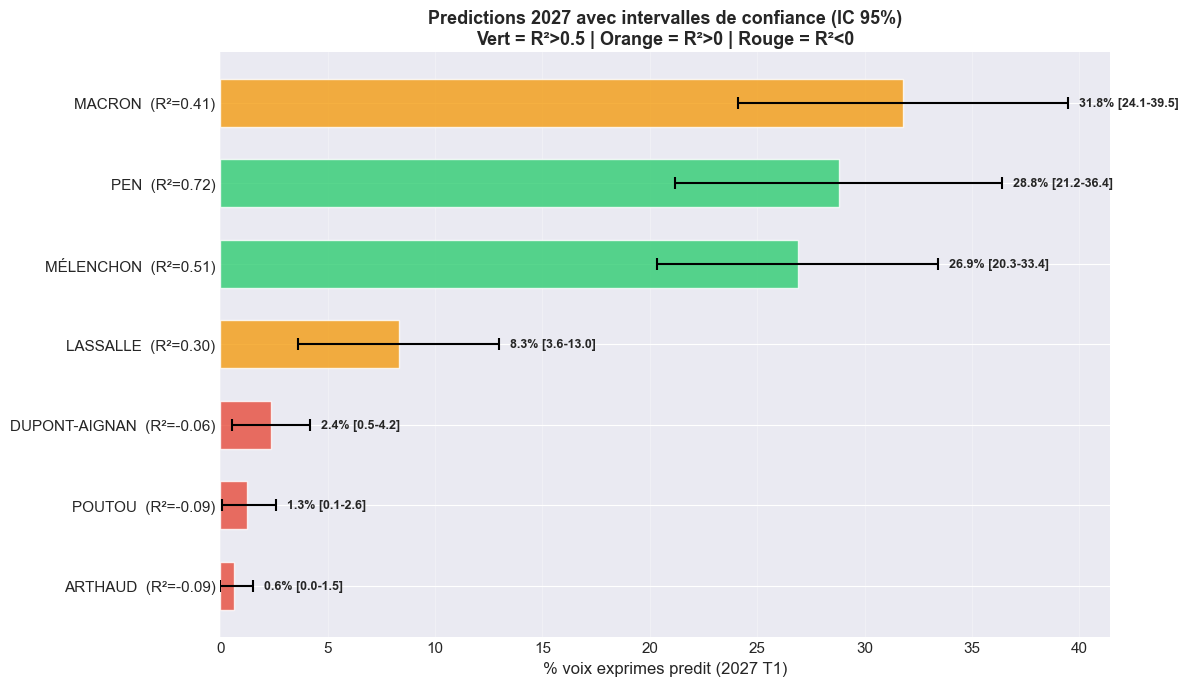

Figure sauvegardee : intervalles_confiance_2027.png


In [4]:
# ============================================================
# FIGURE 2 : Intervalles de confiance par candidat
# ============================================================

# Moyennes ponderees + IC moyens par candidat
ic_data = []
for candidat in candidats_communs:
    sub = df_pred[df_pred['candidat'] == candidat]
    pop = sub['population'].fillna(0)
    if pop.sum() > 0:
        moy = np.average(sub['pourcentage_predit'], weights=pop)
        ic_inf = np.average(sub['intervalle_confiance_inf'], weights=pop)
        ic_sup = np.average(sub['intervalle_confiance_sup'], weights=pop)
    else:
        moy = sub['pourcentage_predit'].mean()
        ic_inf = sub['intervalle_confiance_inf'].mean()
        ic_sup = sub['intervalle_confiance_sup'].mean()
    
    # Extraire R2 du JSONB
    metriques = sub['metriques_modele'].iloc[0]
    if isinstance(metriques, str):
        metriques = json.loads(metriques)
    r2 = metriques.get('r2', 0) if metriques else 0
    
    ic_data.append({
        'candidat': candidat.split()[-1],
        'pct': moy,
        'ic_inf': ic_inf,
        'ic_sup': ic_sup,
        'r2': r2
    })

df_ic = pd.DataFrame(ic_data).sort_values('pct', ascending=True)

fig, ax = plt.subplots(figsize=(12, 7))

y_pos = range(len(df_ic))
colors_bar = ['#2ecc71' if r2 > 0.5 else '#f39c12' if r2 > 0 else '#e74c3c' for r2 in df_ic['r2']]

# Barres horizontales
bars = ax.barh(y_pos, df_ic['pct'], color=colors_bar, alpha=0.8, edgecolor='white', height=0.6)

# Barres d'erreur (IC 95%)
xerr_low = df_ic['pct'].values - df_ic['ic_inf'].values
xerr_high = df_ic['ic_sup'].values - df_ic['pct'].values
ax.errorbar(df_ic['pct'], y_pos, xerr=[xerr_low, xerr_high],
            fmt='none', ecolor='black', elinewidth=1.5, capsize=4, capthick=1.5)

# Labels
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{c}  (R²={r2:.2f})" for c, r2 in zip(df_ic['candidat'], df_ic['r2'])], fontsize=11)
ax.set_xlabel('% voix exprimes predit (2027 T1)', fontsize=12)
ax.set_title('Predictions 2027 avec intervalles de confiance (IC 95%)\n'
             'Vert = R²>0.5 | Orange = R²>0 | Rouge = R²<0',
             fontsize=13, fontweight='bold')

# Annotations valeurs
for i, (pct, ic_l, ic_h) in enumerate(zip(df_ic['pct'], df_ic['ic_inf'], df_ic['ic_sup'])):
    ax.text(ic_h + 0.5, i, f'{pct:.1f}% [{ic_l:.1f}-{ic_h:.1f}]',
            va='center', fontsize=9, fontweight='bold')

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../docs/figures/visualisation/intervalles_confiance_2027.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure sauvegardee : intervalles_confiance_2027.png')

In [5]:
# ============================================================
# FIGURE 3 : Carte chorolethe - Predictions par commune
# ============================================================
# Utilise les contours GeoJSON des communes de Gironde via geo.api.gouv.fr

try:
    import folium
    from folium.plugins import FloatImage
    import requests
    HAS_FOLIUM = True
except ImportError:
    HAS_FOLIUM = False
    print('Folium non installe. pip install folium')

if HAS_FOLIUM:
    # Telecharger GeoJSON des communes de Gironde
    url_geojson = 'https://geo.api.gouv.fr/departements/33/communes?format=geojson&geometry=contour'
    print('Telechargement GeoJSON communes Gironde...')
    resp = requests.get(url_geojson, timeout=30)
    geojson_data = resp.json()
    print(f'{len(geojson_data["features"])} communes dans le GeoJSON')
    
    # Candidat principal predit par commune (celui avec le plus haut %)
    pivot_pred = df_pred.pivot_table(
        index='id_territoire', columns='candidat',
        values='pourcentage_predit', aggfunc='first'
    )
    pivot_pred['gagnant'] = pivot_pred.idxmax(axis=1)
    pivot_pred['pct_gagnant'] = pivot_pred.max(axis=1, numeric_only=True)
    
    # Couleurs par candidat pour la carte
    couleurs_carte = {
        'Emmanuel MACRON': '#FFD700',
        'Marine LE PEN': '#0D2B52',
        'Jean-Luc MELENCHON': '#CC0000',
        'Jean-Luc MÉLENCHON': '#CC0000',
        'Jean LASSALLE': '#87CEEB',
        'Nathalie ARTHAUD': '#8B0000',
        'Nicolas DUPONT-AIGNAN': '#4169E1',
        'Philippe POUTOU': '#FF6347'
    }
    
    # Creer la carte centree sur la Gironde
    m = folium.Map(location=[44.84, -0.58], zoom_start=9, tiles='cartodbpositron')
    
    # Ajouter les communes colorees par gagnant
    for feature in geojson_data['features']:
        code_insee = feature['properties'].get('code', '')
        nom = feature['properties'].get('nom', '')
        
        if code_insee in pivot_pred.index:
            gagnant = pivot_pred.loc[code_insee, 'gagnant']
            pct = pivot_pred.loc[code_insee, 'pct_gagnant']
            couleur = couleurs_carte.get(gagnant, '#888888')
            
            # Tooltip avec details
            tooltip_text = f'<b>{nom}</b><br>'
            for candidat in candidats_communs:
                if candidat in pivot_pred.columns:
                    val = pivot_pred.loc[code_insee, candidat]
                    marker = ' ◀' if candidat == gagnant else ''
                    tooltip_text += f'{candidat.split()[-1]}: {val:.1f}%{marker}<br>'
            
            folium.GeoJson(
                feature,
                style_function=lambda x, c=couleur, p=pct: {
                    'fillColor': c,
                    'color': 'white',
                    'weight': 0.5,
                    'fillOpacity': min(0.4 + (p / 100), 0.85)
                },
                tooltip=folium.Tooltip(tooltip_text)
            ).add_to(m)
        else:
            folium.GeoJson(
                feature,
                style_function=lambda x: {
                    'fillColor': '#cccccc',
                    'color': 'white',
                    'weight': 0.5,
                    'fillOpacity': 0.3
                },
                tooltip=f'{nom} (pas de prediction)'
            ).add_to(m)
    
    # Legende
    legend_html = '''
    <div style="position: fixed; bottom: 30px; left: 30px; z-index: 1000;
                background-color: white; padding: 12px; border-radius: 5px;
                border: 2px solid grey; font-size: 12px;">
        <b>Candidat en tete (2027 T1)</b><br>
    '''
    for cand, color in couleurs_carte.items():
        if cand in candidats_communs:
            legend_html += f'<i style="background:{color};width:12px;height:12px;display:inline-block;margin-right:5px;"></i> {cand.split()[-1]}<br>'
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Sauvegarder
    m.save('../docs/figures/visualisation/carte_predictions_2027.html')
    print('Carte sauvegardee : carte_predictions_2027.html')
    m

Telechargement GeoJSON communes Gironde...
534 communes dans le GeoJSON
Carte sauvegardee : carte_predictions_2027.html


In [6]:
# ============================================================
# FIGURE 4 : Carte chorolethe MACRON - % predit par commune
# ============================================================

if HAS_FOLIUM:
    import branca.colormap as cm
    
    # Trouver le nom exact de Macron dans les predictions
    macron_name = [c for c in candidats_communs if 'MACRON' in c.upper()][0]
    
    macron_pred = df_pred[df_pred['candidat'] == macron_name].set_index('id_territoire')['pourcentage_predit']
    
    # Colormap
    vmin, vmax = macron_pred.min(), macron_pred.max()
    colormap = cm.LinearColormap(['#fff7bc', '#fec44f', '#d95f0e'], vmin=vmin, vmax=vmax,
                                  caption=f'{macron_name} - % predit 2027 T1')
    
    m2 = folium.Map(location=[44.84, -0.58], zoom_start=9, tiles='cartodbpositron')
    
    for feature in geojson_data['features']:
        code = feature['properties'].get('code', '')
        nom = feature['properties'].get('nom', '')
        
        if code in macron_pred.index:
            val = float(macron_pred.loc[code])
            folium.GeoJson(
                feature,
                style_function=lambda x, v=val: {
                    'fillColor': colormap(v),
                    'color': 'grey',
                    'weight': 0.3,
                    'fillOpacity': 0.7
                },
                tooltip=f'{nom}: {val:.1f}%'
            ).add_to(m2)
    
    colormap.add_to(m2)
    m2.save('../docs/figures/visualisation/carte_macron_2027.html')
    print('Carte Macron sauvegardee : carte_macron_2027.html')
    m2

Carte Macron sauvegardee : carte_macron_2027.html


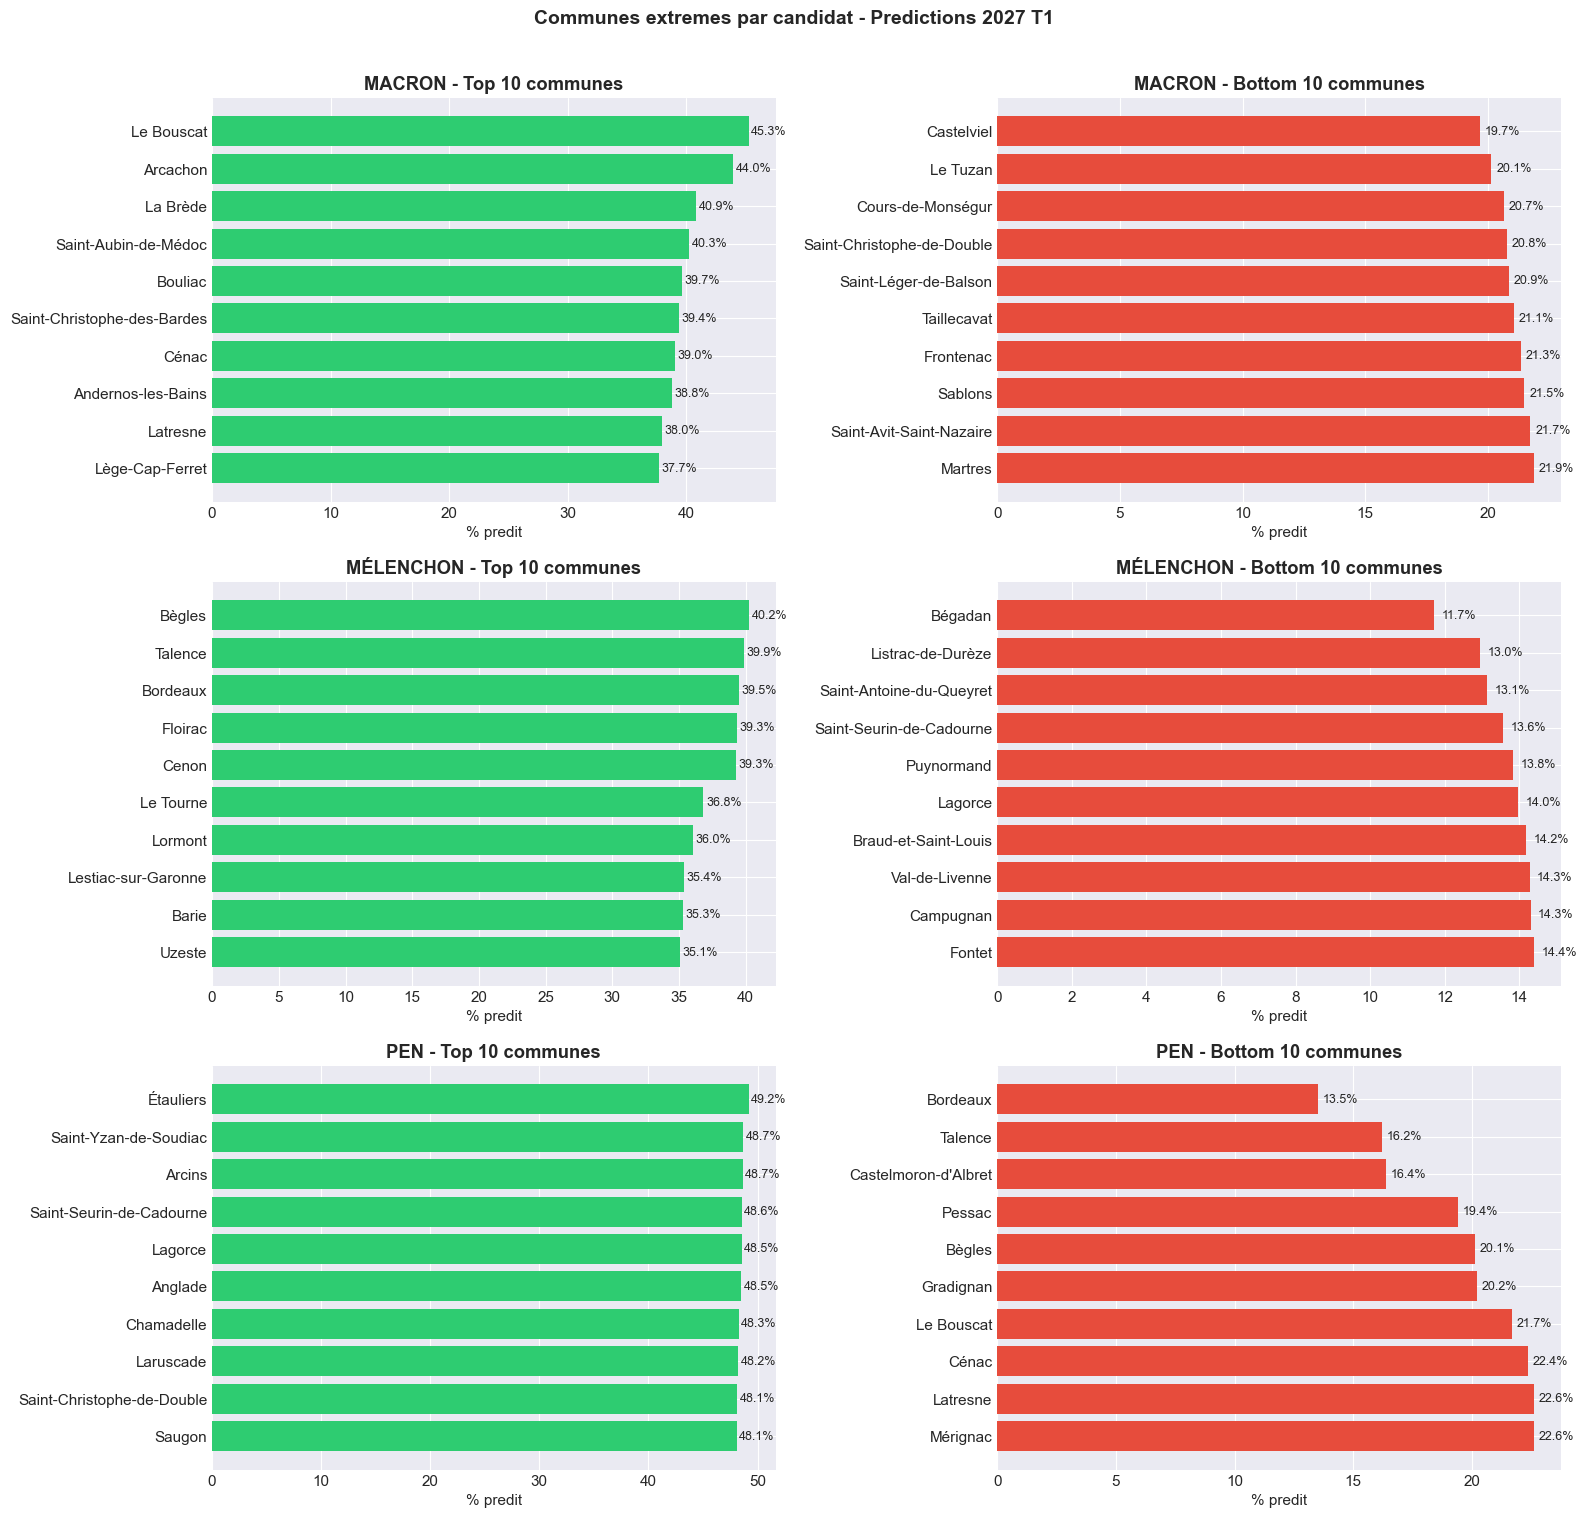

Figure sauvegardee : top_bottom_communes.png


In [7]:
# ============================================================
# FIGURE 5 : Top 10 / Bottom 10 communes par candidat majeur
# ============================================================

# 3 candidats principaux
focus = [c for c in candidats_communs if any(n in c.upper() for n in ['MACRON', 'PEN', 'MELENCHON', 'MÉLENCHON'])]
if len(focus) < 3:
    focus = candidats_communs[:3]

fig, axes = plt.subplots(len(focus), 2, figsize=(16, 5 * len(focus)))

for i, candidat in enumerate(focus):
    sub = df_pred[df_pred['candidat'] == candidat].copy()
    sub = sub.sort_values('pourcentage_predit', ascending=False)
    
    # Top 10
    top10 = sub.head(10)
    ax_top = axes[i, 0] if len(focus) > 1 else axes[0]
    ax_top.barh(top10['nom_commune'], top10['pourcentage_predit'], color='#2ecc71')
    ax_top.set_xlabel('% predit')
    ax_top.set_title(f'{candidat.split()[-1]} - Top 10 communes', fontweight='bold')
    ax_top.invert_yaxis()
    for j, v in enumerate(top10['pourcentage_predit']):
        ax_top.text(v + 0.2, j, f'{v:.1f}%', va='center', fontsize=9)
    
    # Bottom 10
    bottom10 = sub.tail(10).sort_values('pourcentage_predit', ascending=True)
    ax_bot = axes[i, 1] if len(focus) > 1 else axes[1]
    ax_bot.barh(bottom10['nom_commune'], bottom10['pourcentage_predit'], color='#e74c3c')
    ax_bot.set_xlabel('% predit')
    ax_bot.set_title(f'{candidat.split()[-1]} - Bottom 10 communes', fontweight='bold')
    ax_bot.invert_yaxis()
    for j, v in enumerate(bottom10['pourcentage_predit']):
        ax_bot.text(v + 0.2, j, f'{v:.1f}%', va='center', fontsize=9)

plt.suptitle('Communes extremes par candidat - Predictions 2027 T1', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../docs/figures/visualisation/top_bottom_communes.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure sauvegardee : top_bottom_communes.png')

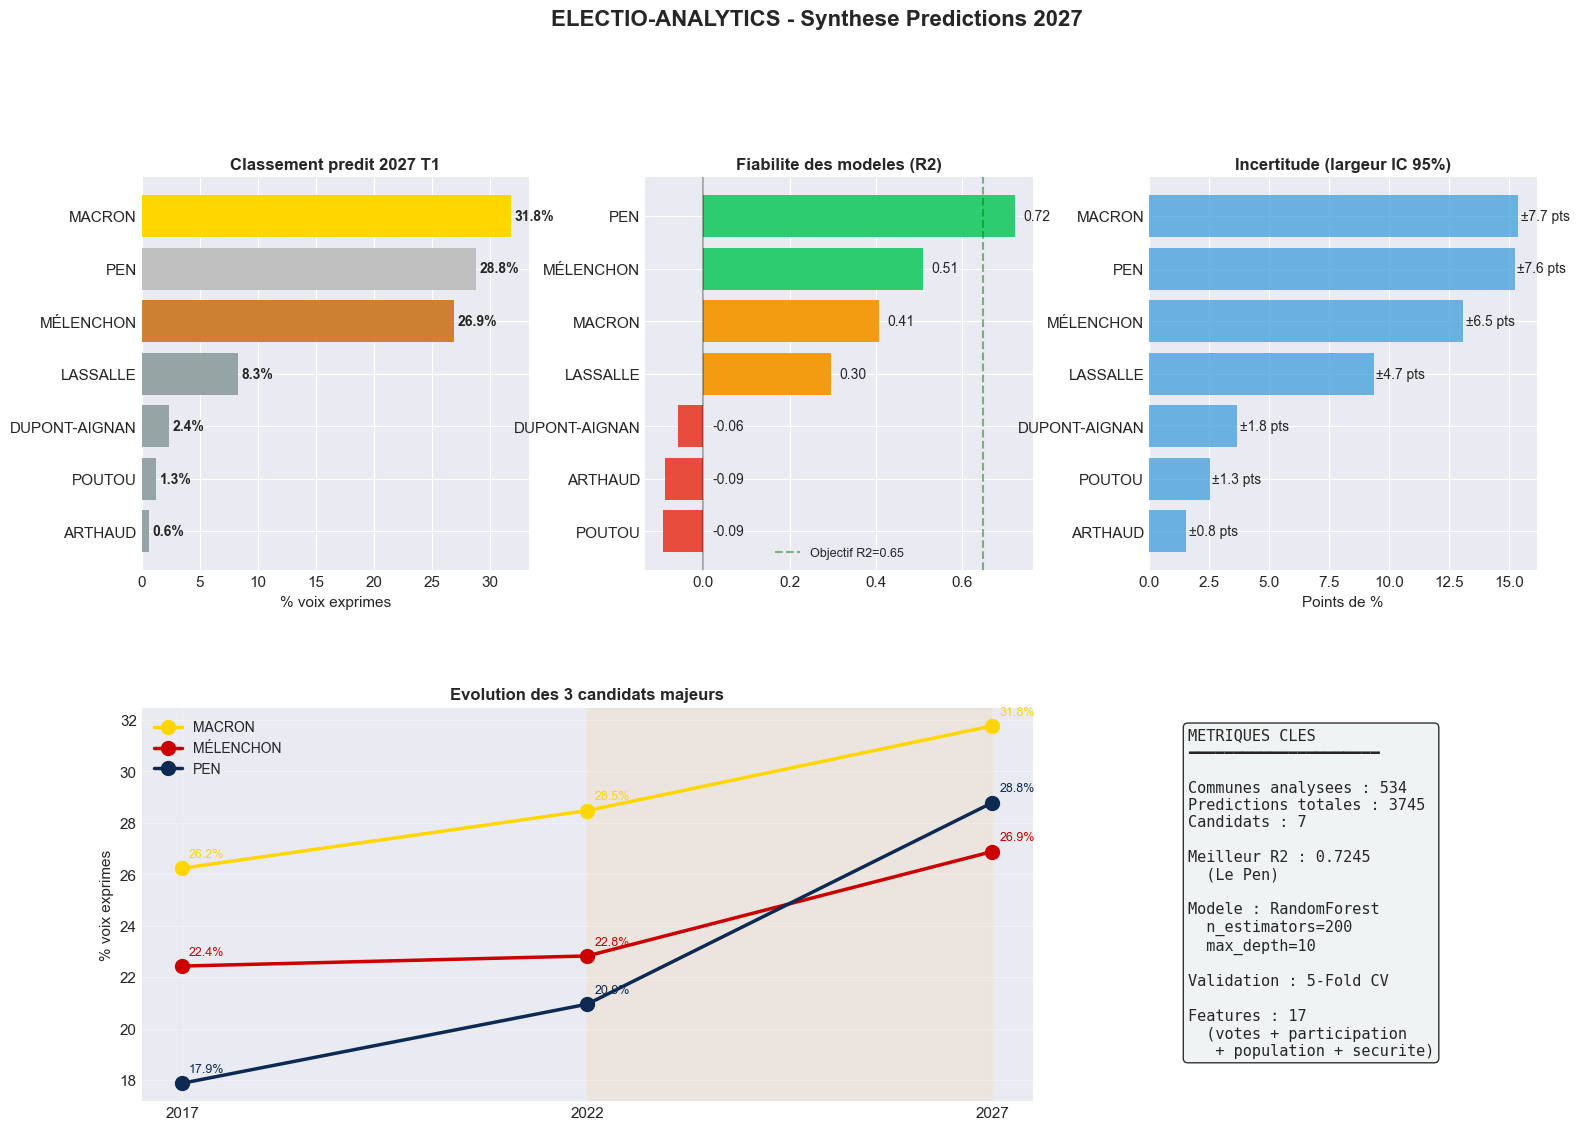

Figure sauvegardee : dashboard_synthese.png


In [8]:
# ============================================================
# FIGURE 6 : Synthese - Dashboard recapitulatif
# ============================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# --- Panel 1 : Podium 2027 ---
ax1 = fig.add_subplot(gs[0, 0])
df_podium = df_ic.sort_values('pct', ascending=False).head(7)
colors_podium = ['#FFD700', '#C0C0C0', '#CD7F32'] + ['#95a5a6'] * 4
ax1.barh(df_podium['candidat'][::-1], df_podium['pct'][::-1], color=colors_podium[::-1])
for i, (v, c) in enumerate(zip(df_podium['pct'][::-1], df_podium['candidat'][::-1])):
    ax1.text(v + 0.3, i, f'{v:.1f}%', va='center', fontweight='bold', fontsize=10)
ax1.set_title('Classement predit 2027 T1', fontweight='bold', fontsize=12)
ax1.set_xlabel('% voix exprimes')

# --- Panel 2 : R2 par candidat ---
ax2 = fig.add_subplot(gs[0, 1])
df_r2 = df_ic.sort_values('r2', ascending=True)
colors_r2 = ['#2ecc71' if r > 0.5 else '#f39c12' if r > 0 else '#e74c3c' for r in df_r2['r2']]
ax2.barh(df_r2['candidat'], df_r2['r2'], color=colors_r2)
ax2.axvline(0.65, color='green', ls='--', alpha=0.5, label='Objectif R2=0.65')
ax2.axvline(0, color='black', ls='-', alpha=0.3)
for i, v in enumerate(df_r2['r2']):
    ax2.text(max(v, 0) + 0.02, i, f'{v:.2f}', va='center', fontsize=10)
ax2.set_title('Fiabilite des modeles (R2)', fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)

# --- Panel 3 : Largeur IC ---
ax3 = fig.add_subplot(gs[0, 2])
df_ic_sorted = df_ic.sort_values('pct', ascending=False)
ic_width = df_ic_sorted['ic_sup'] - df_ic_sorted['ic_inf']
ax3.barh(df_ic_sorted['candidat'][::-1], ic_width[::-1], color='#3498db', alpha=0.7)
for i, (w, c) in enumerate(zip(ic_width[::-1], df_ic_sorted['candidat'][::-1])):
    ax3.text(w + 0.1, i, f'±{w/2:.1f} pts', va='center', fontsize=10)
ax3.set_title('Incertitude (largeur IC 95%)', fontweight='bold', fontsize=12)
ax3.set_xlabel('Points de %')

# --- Panel 4 : Evolution 3 candidats majeurs ---
ax4 = fig.add_subplot(gs[1, 0:2])
for candidat in focus:
    sub = df_evo[df_evo['candidat'] == candidat].sort_values('annee')
    couleur = couleurs.get(candidat, '#888888')
    nom_court = candidat.split()[-1]
    ax4.plot(sub['annee'], sub['pct'], marker='o', color=couleur,
             linewidth=2.5, markersize=10, label=nom_court)
    for _, row in sub.iterrows():
        ax4.annotate(f'{row["pct"]:.1f}%', xy=(row['annee'], row['pct']),
                     xytext=(5, 8), textcoords='offset points',
                     fontsize=9, color=couleur)

ax4.set_xticks([2017, 2022, 2027])
ax4.axvspan(2022, 2027, alpha=0.08, color='orange')
ax4.set_title('Evolution des 3 candidats majeurs', fontweight='bold', fontsize=12)
ax4.set_ylabel('% voix exprimes')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# --- Panel 5 : Metriques cles ---
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis('off')
metriques_text = (
    'METRIQUES CLES\n'
    '━━━━━━━━━━━━━━━━━━━━━\n\n'
    f'Communes analysees : 534\n'
    f'Predictions totales : {len(df_pred)}\n'
    f'Candidats : {len(candidats_communs)}\n\n'
    f'Meilleur R2 : 0.7245\n'
    f'  (Le Pen)\n\n'
    f'Modele : RandomForest\n'
    f'  n_estimators=200\n'
    f'  max_depth=10\n\n'
    f'Validation : 5-Fold CV\n\n'
    f'Features : 17\n'
    f'  (votes + participation\n'
    f'   + population + securite)'
)
ax5.text(0.1, 0.95, metriques_text, transform=ax5.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#ecf0f1', alpha=0.8))

fig.suptitle('ELECTIO-ANALYTICS - Synthese Predictions 2027',
             fontsize=16, fontweight='bold', y=1.02)
plt.savefig('../docs/figures/visualisation/dashboard_synthese.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure sauvegardee : dashboard_synthese.png')

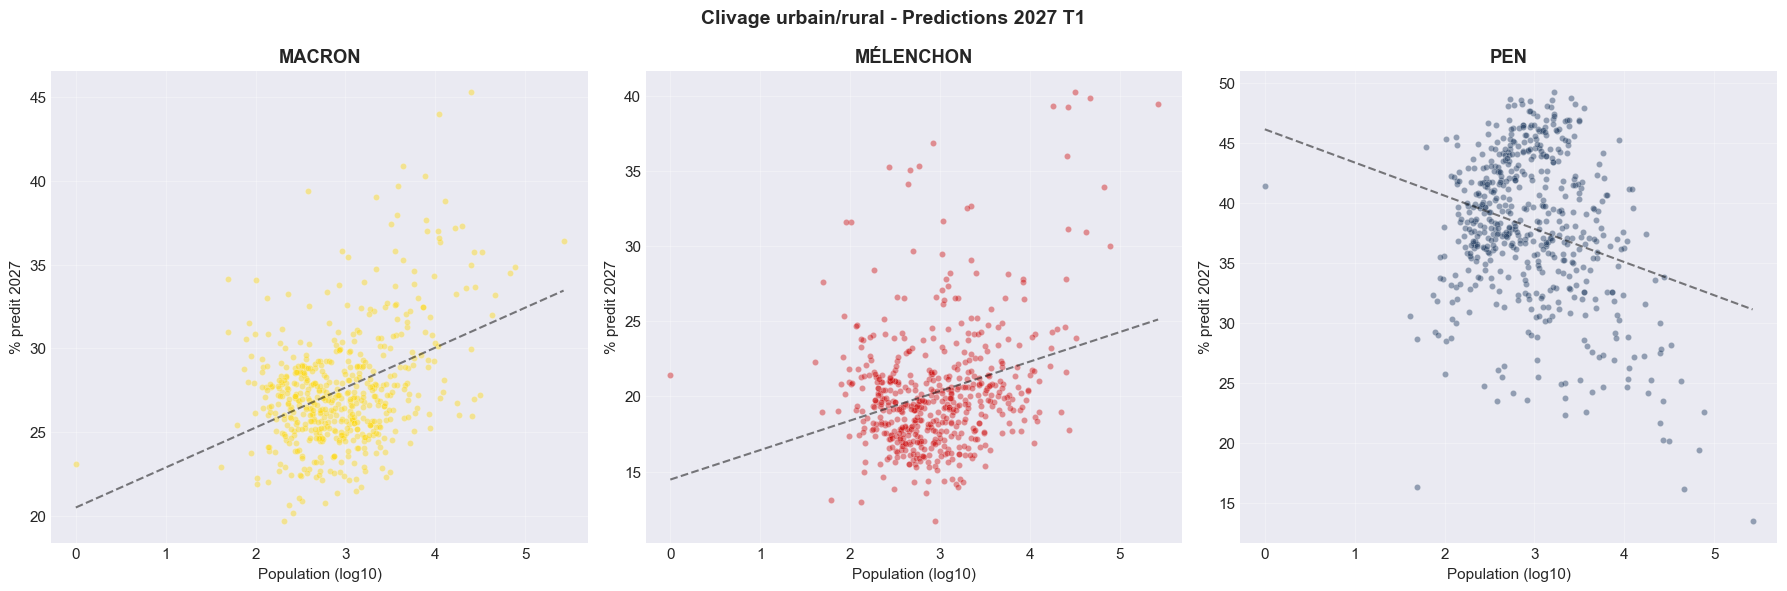

Figure sauvegardee : clivage_urbain_rural.png


In [9]:
# ============================================================
# FIGURE 7 : Dispersion urbain vs rural
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, candidat in zip(axes, focus):
    sub = df_pred[df_pred['candidat'] == candidat].copy()
    sub['log_pop'] = np.log10(sub['population'].fillna(1).clip(lower=1))
    couleur = couleurs.get(candidat, '#888888')
    
    ax.scatter(sub['log_pop'], sub['pourcentage_predit'],
               alpha=0.4, s=20, c=couleur, edgecolors='white', linewidths=0.3)
    
    # Tendance (regression lineaire)
    z = np.polyfit(sub['log_pop'].dropna(), sub.loc[sub['log_pop'].notna(), 'pourcentage_predit'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(sub['log_pop'].min(), sub['log_pop'].max(), 100)
    ax.plot(x_trend, p(x_trend), 'k--', alpha=0.5, linewidth=1.5)
    
    ax.set_xlabel('Population (log10)')
    ax.set_ylabel('% predit 2027')
    ax.set_title(candidat.split()[-1], fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Clivage urbain/rural - Predictions 2027 T1', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/figures/visualisation/clivage_urbain_rural.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure sauvegardee : clivage_urbain_rural.png')

In [10]:
# Fermer session
session.close()

print('\n=== Phase 5 - Visualisations terminees ===')
print(f'Figures generees dans docs/figures/visualisation/ :')
for f in sorted(os.listdir('../docs/figures/visualisation')):
    if not f.startswith('.'):
        size = os.path.getsize(f'../docs/figures/visualisation/{f}')
        print(f'  {f} ({size/1024:.0f} KB)')


=== Phase 5 - Visualisations terminees ===
Figures generees dans docs/figures/visualisation/ :
  carte_macron_2027.html (4894 KB)
  carte_predictions_2027.html (4950 KB)
  clivage_urbain_rural.png (245 KB)
  dashboard_synthese.png (238 KB)
  evolution_2017_2022_2027.png (128 KB)
  intervalles_confiance_2027.png (90 KB)
  top_bottom_communes.png (303 KB)


## Recapitulatif des figures

| # | Figure | Type | Fichier |
|---|--------|------|--------|
| 1 | Evolution 2017→2022→2027 | Courbes temporelles | `evolution_2017_2022_2027.png` |
| 2 | Intervalles de confiance | Barres d'erreur | `intervalles_confiance_2027.png` |
| 3 | Carte candidat en tete | Chorolethe Folium | `carte_predictions_2027.html` |
| 4 | Carte Macron gradient | Chorolethe Folium | `carte_macron_2027.html` |
| 5 | Top/Bottom communes | Barplots comparatifs | `top_bottom_communes.png` |
| 6 | Dashboard synthese | Multi-panel | `dashboard_synthese.png` |
| 7 | Clivage urbain/rural | Scatter + tendance | `clivage_urbain_rural.png` |

---

**Total :** 5 figures PNG + 2 cartes HTML interactives